# Severe Weather Analysis and Forecasting with Python Tools
David John Gagne, National Center for Atmospheric Research

## Outline
1. Severe Weather Analysis
    1. Upper Air Analysis
    2. Surface Analysis
    3. Sounding Data
2. Severe Weather Forecasting
    1. NCAR Ensemble Forecast Analysis
    2. NCAR Ensemble Storm Patches
3. Severe Weather Verification
    1. Verifying the NCAR Ensemble Forecast

In [50]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.basemap import Basemap
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

## Upper Air Analysis


In [190]:
analysis_date = pd.Timestamp("2017-03-24 12:00")
web_path = "http://www.mesonet.org/data/public/noaa/upperair/mdf/"
upper_air = pd.read_table(web_path + "{0}/{1}00.mdf".format(analysis_date.strftime("%Y/%m/%d"),
                                                            analysis_date.strftime("%Y%m%d%H")),
                          skiprows=2, 
                          delim_whitespace=True)
upper_air_us = upper_air.loc[(upper_air["LON"] > -125) & (upper_air["LON"] < -60) & (upper_air["LAT"] > 20) & 
                             (upper_air["LAT"] < 55)]


In [174]:
upper_air_us

,STID,STNM,TIME,LAT,LON,ELEV,TAIR_SFC,TDEW_SFC,WDIR_SFC,WSPD_SFC,...,WDIR_150,WSPD_150,HGHT_150,TAIR_100,TDEW_100,WDIR_100,WSPD_100,HGHT_100,X,Y
370,CWSE,957,0,53.53,-114.10,766.0,8.4,-3.5,340.0,9.0,...,175.0,9.0,13580,-52.9,-85.8,15.0,5.0,16210,1.478873e+06,3.552661e+06
371,CYLW,962,0,49.97,-119.38,430.0,19.8,-0.1,280.0,3.0,...,290.0,18.0,13610,-53.3,-86.2,315.0,10.0,16230,1.023975e+06,3.220650e+06
372,CWSA,964,0,43.93,-60.01,4.0,6.8,4.6,220.0,13.0,...,245.0,37.0,13670,-54.3,-87.2,210.0,27.0,16310,5.603047e+06,2.896746e+06
373,CYQI,965,0,43.86,-66.10,9.0,8.0,0.0,260.0,8.0,...,255.0,50.0,13630,-54.7,-86.6,270.0,24.0,16270,5.139843e+06,2.724633e+06
374,CWMW,971,0,46.38,-75.96,173.0,10.2,-4.7,340.0,7.0,...,305.0,38.0,13630,-51.3,-84.2,300.0,31.0,16240,4.307039e+06,2.797527e+06
375,CYZV,973,0,50.21,-66.25,53.0,4.0,3.2,60.0,1.0,...,255.0,10.0,13540,-49.9,-83.8,260.0,4.0,16220,4.909073e+06,3.410273e+06
377,CYYR,975,0,53.30,-60.36,36.0,2.8,1.6,30.0,2.0,...,145.0,13.0,13560,-48.7,-82.6,230.0,13.0,16230,5.190806e+06,3.890629e+06
378,CYAH,977,0,53.75,-73.66,307.0,5.0,-7.9,10.0,8.0,...,355.0,14.0,13550,-50.7,-84.6,185.0,2.0,16200,4.285571e+06,3.665787e+06
379,CYMO,978,0,51.26,-80.65,10.0,6.4,-10.5,335.0,1.0,...,340.0,24.0,13610,-53.9,-86.8,315.0,21.0,16220,3.854846e+06,3.281824e+06
380,CWPL,980,0,51.45,-90.20,386.0,19.0,-1.9,140.0,11.0,...,265.0,27.0,13680,-56.9,-86.8,285.0,20.0,16240,3.163757e+06,3.223600e+06


In [151]:
plt.scatter(upper_air_us["LON"], upper_air_us["LAT"])

In [187]:
bmap = Basemap(projection="lcc", resolution="l", lon_0=-97, lat_0=35, 
               llcrnrlon=-122, llcrnrlat=22, urcrnrlon=-56, urcrnrlat=50)

/Users/dgagne/anaconda3/envs/msu/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<IPython.core.display.Javascript object>


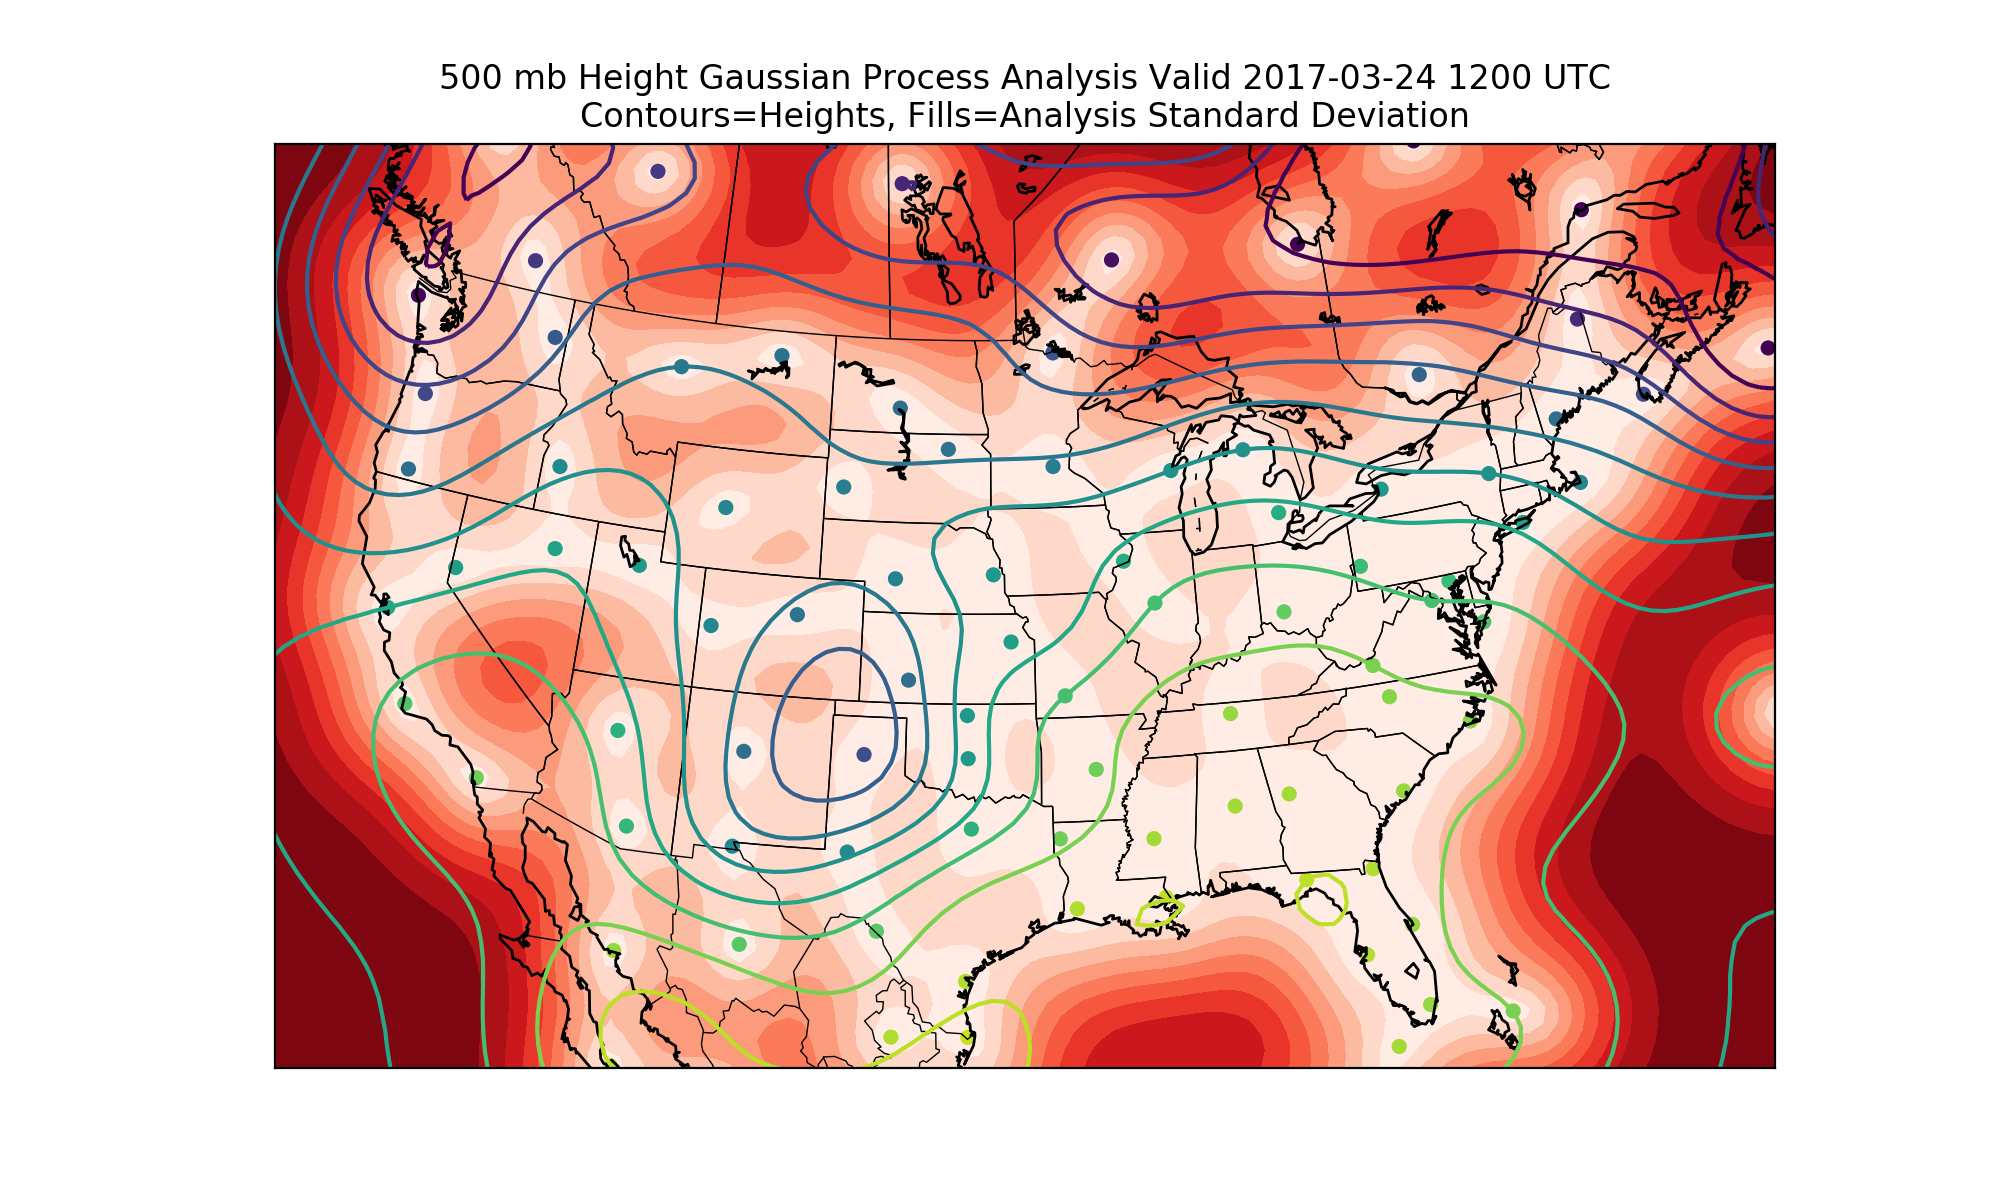

In [192]:
lons = np.arange(-140, -50, 0.5)
lats = np.arange(20, 58, 0.5)
lon_grid, lat_grid = np.meshgrid(lons, lats)
x_grid, y_grid = bmap(lon_grid, lat_grid)
x, y = bmap(upper_air_us["LON"].values, upper_air_us["LAT"].values)
upper_air_us.loc[:, "X"] = x
upper_air_us.loc[:, "Y"] = y
valid = upper_air_us["HGHT_500"] > -900
med = upper_air_us.loc[valid, "HGHT_500"].quantile(0.5)
gp = GaussianProcessRegressor(kernel=RBF(length_scale=100))
gp.fit(upper_air_us.loc[valid, ["X", "Y"]] / 1000, upper_air_us.loc[valid, "HGHT_500"] - med)
vals, vals_sd = gp.predict(np.vstack((x_grid.ravel(), y_grid.ravel())).T / 1000, return_std=True)
plt.figure(figsize=(10, 6))
bmap.drawstates()
bmap.drawcoastlines()
bmap.drawcountries()
plt.contour(x_grid, y_grid, (vals.reshape(lon_grid.shape) + med) / 10, np.arange(540, 595, 5))
plt.contourf(x_grid, y_grid, vals_sd.reshape(lon_grid.shape), np.arange(0, 1.1, 0.1), cmap="Reds")
plt.scatter(x[valid], y[valid], 20, upper_air_us.loc[valid, "HGHT_500"].values / 10, vmin=540, vmax=590)
plt.title("500 mb Height Gaussian Process Analysis Valid {0}\nContours=Heights, Fills=Analysis Standard Deviation".format(analysis_date.strftime("%Y-%m-%d %H%M UTC")))
plt.savefig("height_500mb_gp_analysis.png", dpi=200, bbox_inches="tight")